In [1]:
using ConstrainedSystems

In [2]:
using LinearAlgebra

In [ ]:
using CartesianGrids

In [3]:
using Plots
pyplot()

Plots.PyPlotBackend()

### Basic unconstrained system

First, we will solve a basic system

$\frac{\displaystyle du}{\displaystyle dt} = \cos(\omega t)$

with $u(0) = u_0$. The exact solution is

$u(t) = u_0 + \frac{\displaystyle 1}{\displaystyle \omega}\sin(\omega t)$

In [3]:
ω = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω*t)/ω

uex (generic function with 1 method)

In [4]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
ConstrainedSystems.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
solver = RK(u,Δt,r₁,rk=ConstrainedSystems.RK31)

Order-3 RK integator with
   State of type Array{Float64,1}
   Time step size 0.005


In [5]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u = solver(t,u)
end

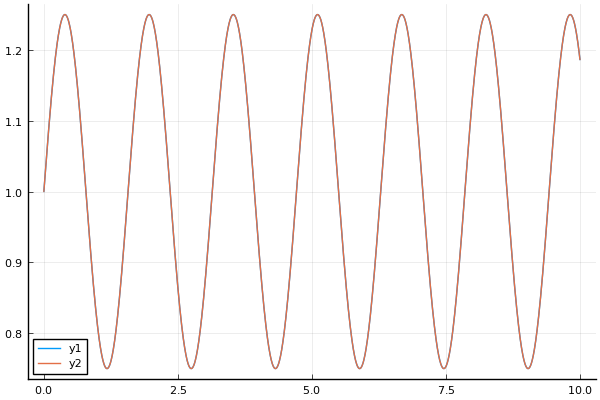

In [6]:
plot(T,uhist)
plot!(T,uex.(T))

### Unconstrained system with integrating factor

Next, we will solve an unconstrained system with an integrating factor

$\frac{\displaystyle du}{\displaystyle dt} = -\alpha u + \cos(\omega t)$

with $u(0) = u_0$. The exact solution is

$u(t) = u_0 e^{-\alpha t} + \frac{\displaystyle 1}{\displaystyle \alpha^2+\omega^2}\left(\alpha(\cos(\omega t)-e^{-\alpha t})+\omega \sin(\omega t)\right) $

In [7]:
α = 0.5
ω = 4
u₀ = 1.0
uex(t) = u₀*exp(-α*t) + (α*(cos(ω*t)-exp(-α*t))+ω*sin(ω*t))/(α^2+ω^2)

uex (generic function with 1 method)

Set up the integrating factor constructor

In [8]:
CartesianGrids.plan_intfact(t::Float64,u::Vector{Float64}) = exp(-α*t)

In [9]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
ConstrainedSystems.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
solver = IFRK(u,Δt,plan_intfact,r₁,rk=ConstrainedSystems.RK31)

Order-3 IF-RK integator with
   State of type Array{Float64,1}
   Time step size 0.005


In [10]:
t = 0.0
u = [u₀]
uhist = Float64[]
for ti in T
    push!(uhist,u[1])
    global t,u = solver(t,u)
end

In [29]:
import LinearAlgebra: norm, I

In [12]:
norm(uhist-uex.(T))

0.0005014844446813186

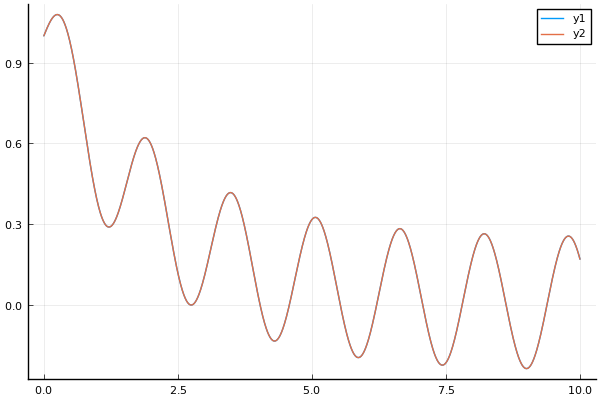

In [13]:
plot(T,uhist)
plot!(T,uex.(T))

### Constrained system with integrating factor

Now let's do a more interesting example: 2-d diffusion from a circle

In [14]:
nx = 129; ny = 129; Lx = 2.0; Δx = Lx/(nx-2);
u₀ = Nodes(Dual,(nx,ny)); # field initial condition

In [15]:
n = 128; θ = range(0,stop=2π,length=n+1);
R = 0.5; xb = 1.0 .+ R*cos.(θ); yb = 1.0 .+ R*sin.(θ);
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X); #

In [16]:
reg = Regularize(X,Δx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(reg,f,u₀);
plan_constraints(u::Nodes{Dual,nx,ny},t::Float64) = Hmat, Emat

plan_constraints (generic function with 1 method)

In [17]:
ConstrainedSystems.r₁(u::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = Nodes(T,u); # sets to zeros
ConstrainedSystems.r₂(u::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = 1.0; # sets uniformly to 1.0

In [18]:
Δt = 1.0;
t = 0.0;
u = deepcopy(u₀);

In [19]:
solver = IFHERK(u,f,Δt,CartesianGrids.plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.Euler)

Order-1 IF-HERK integrator with
   State of type Nodes{Dual,129,129,Float64,Array{Float64,2}}
   Force of type ScalarData{128,Float64,Array{Float64,1}}
   Time step size 1.0


In [20]:
@time for i = 1:20
  global t, u, f = solver(t,u)
end

  1.808066 seconds (4.78 M allocations: 271.125 MiB, 8.12% gc time)


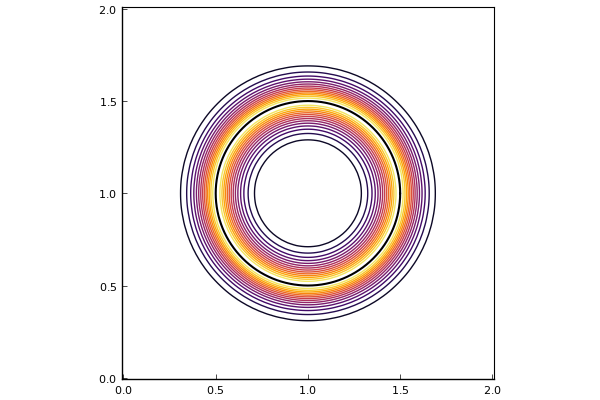

In [21]:
xg, yg = coordinates(u,dx=Δx);
plot(xg,yg,u)
plot!(xb,yb,linecolor=:black,linewidth=1.5)

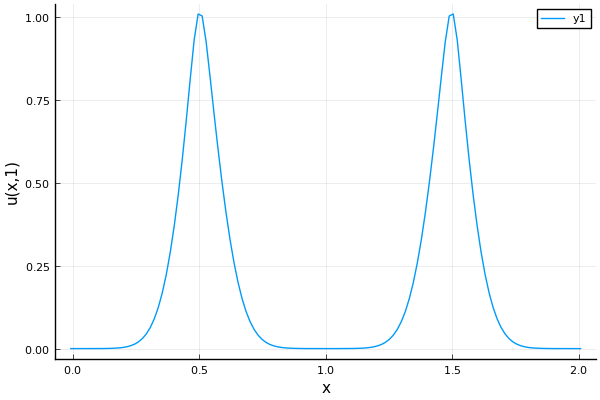

In [22]:
plot(xg,u[65,:],xlabel="x",ylabel="u(x,1)")

### Pendulum example

In [4]:
θ₀ = 0.0; #π/2+0.002;
l = 1.0
g = 1.0
m = 1.0
u₀ = Float64[l*cos(θ₀),l*sin(θ₀),0,0]
f₀ = Float64[0.0, 0.0];

In [5]:
construct_B₁ᵀ(u) = (B₁ᵀ = zeros(4,2); B₁ᵀ[3,1] = u[1]; B₁ᵀ[4,1] = u[2]; B₁ᵀ[1,2] = u[1]; B₁ᵀ[2,2] = u[2]; B₁ᵀ)
construct_B₂(u) = (B₂ = zeros(2,4); B₂[1,3] = u[1]; B₂[1,4] = u[2]; B₂[2,1] = u[1]; B₂[2,2] = u[2]; B₂)

construct_B₂ (generic function with 1 method)

In [6]:
my_plan_constraints(u::Vector{Float64},t::Float64) = construct_B₁ᵀ(u), construct_B₂(u)
my_plan_intfact(t::Float64,u::Vector{Float64}) = Matrix(1.0I,length(u),length(u))
my_r₁(u::Vector{Float64},t::Float64) = (rhs = zero(u); rhs[1] = u[3]; rhs[2] = u[4]; rhs[4] = -g; rhs)
my_r₂(u::Vector{Float64},t::Float64) = [0.0, l^2];

In [7]:
Δt = 5e-4;
solver = IFHERK(u₀,f₀,Δt,my_plan_intfact,my_plan_constraints,(my_r₁,my_r₂),rk=ConstrainedSystems.RK31,isstaticconstraints = false)

Order-3 IF-HERK integrator with
   State of type Array{Float64,1}
   Force of type Array{Float64,1}
   Time step size 0.0005


In [8]:
t = 0.0
T = 0:Δt:10
u = copy(u₀)
uhist = [deepcopy(u₀)]
fhist = [deepcopy(f₀)]
thist = [t]

1-element Array{Float64,1}:
 0.0

In [9]:
for ti in T
    t,u,f = solver(t,u)
    push!(uhist,deepcopy(u))
    push!(fhist,deepcopy(f))
    push!(thist,t)
end

In [10]:
u_rs = hcat(uhist...);

In [11]:
f_rs = hcat(fhist...)

2×20002 Array{Float64,2}:
 0.0  6.69873e-8   1.25379e-6   3.75759e-6   …  3.04184      3.03954
 0.0  1.68925e-11  1.85817e-10  7.01601e-10     0.000576285  0.000575849

In [12]:
using SpecialFunctions

In [13]:
x = u_rs[1,:]
y = u_rs[2,:]
ẋ = u_rs[3,:]
ẏ = u_rs[4,:]
θ = atan.(y,x);
θ̇ = (-y.*ẋ .+ x.*ẏ)/l^2;
r = sqrt.(x.^2+y.^2);

Texact = 4*ellipk(sin(0.5*(θ₀+π/2))^2)

7.416298709205487

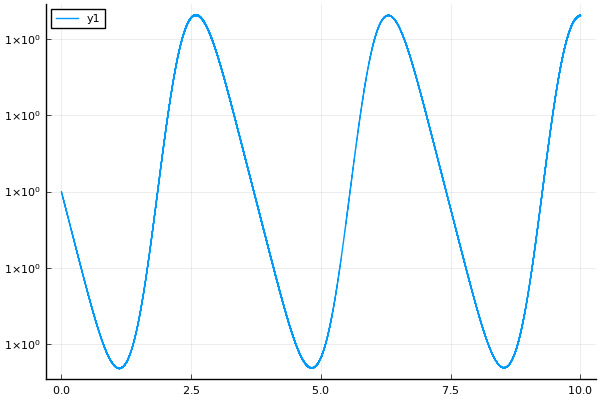

In [14]:
plot(thist,r)

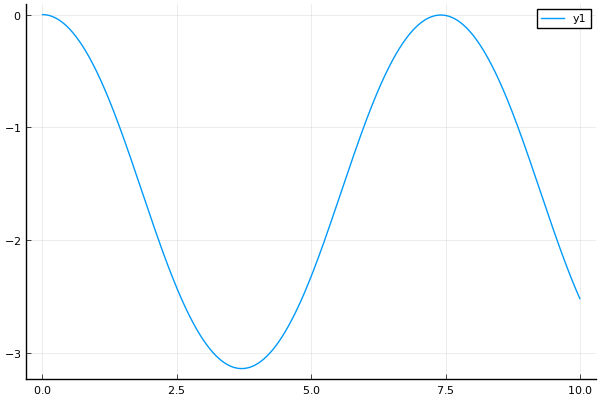

In [15]:
plot(thist,θ)

In [16]:
idex = findall(x -> abs(x) == 2.0,diff(sign.(θ̇)))

2-element Array{Int64,1}:
  7415
 14826

In [17]:
Tzero = []
for i in idex
     push!(Tzero,thist[i]-θ̇[i]*(thist[i+1]-thist[i])/(θ̇[i+1]-θ̇[i]))
end

In [18]:
2*(Tzero[2]-Tzero[1])

7.41104107659892

$$\dot{\theta}(t) = \dot{\theta}_i + \frac{\dot{\theta}_{i+1} - \dot{\theta}_i}{t_{i+1}-t_i} (t - t_i)$$

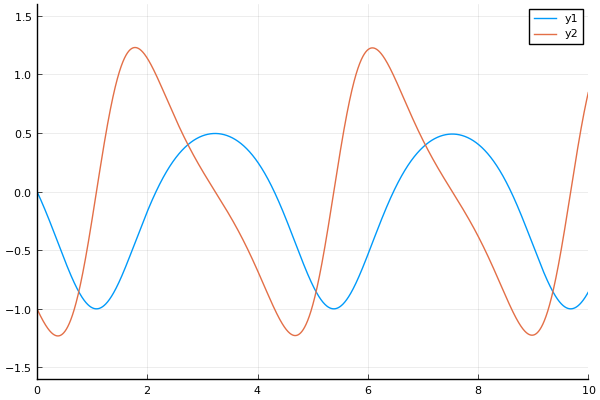

In [209]:
plot(thist/sqrt(g),u_rs[2,:],xlim=(0,10),ylim=(-1.6,1.6))
plot!(thist/sqrt(g),u_rs[4,:])

1-element Array{Int64,1}:
 7411

In [83]:
thist[7411]/sqrt(9.81)

2.3658309244965023

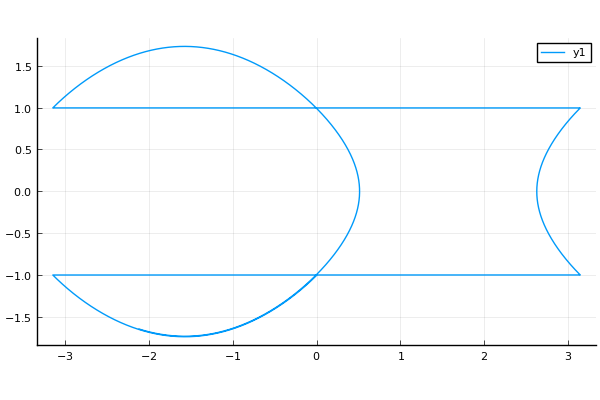

In [210]:
plot(θ,θ̇,ratio=1)

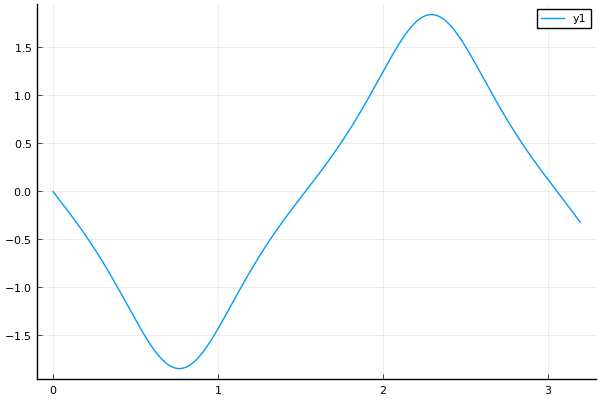

In [131]:
plot(thist/sqrt(9.81),θ̇)

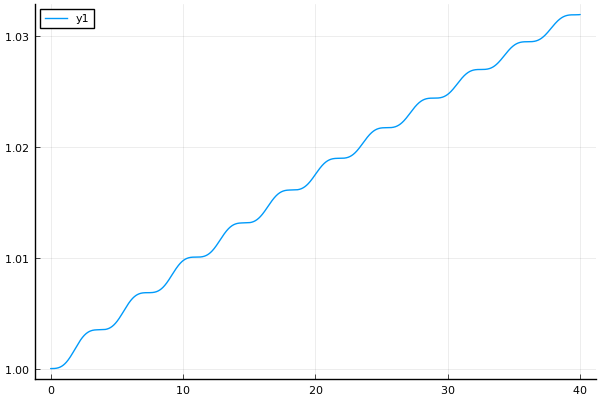

In [39]:
plot(thist,sqrt.(u_rs[1,:].^2+u_rs[2,:].^2))

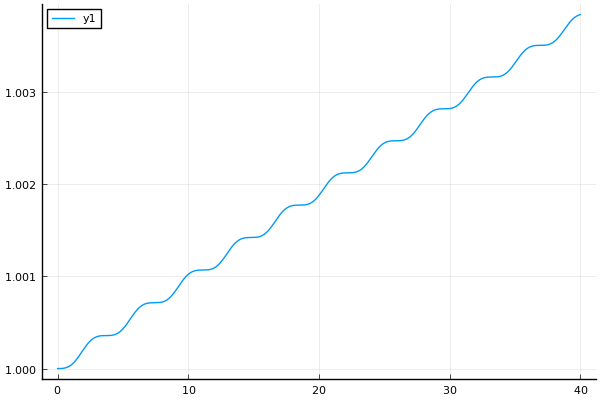

In [44]:
plot(thist,sqrt.(u_rs[1,:].^2+u_rs[2,:].^2))

### Solving basic unconstrained system with IFHERK

In [30]:
ω = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω*t)/ω

uex (generic function with 1 method)

In [31]:
t = 0.0
Δt = 0.005
T = 0:Δt:10
u = [u₀]
f = Vector{Float64}()
ConstrainedSystems.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
ConstrainedSystems.r₂(u::Vector{Float64},t::Float64) = Vector{Float64}()
plan_constraints(u::Vector{Float64},t::Float64) = f -> zeros(Float64,1), u -> Vector{Float64}()
CartesianGrids.plan_intfact(t::Float64,u::Vector{Float64}) = Matrix(1.0I,1,1)
solver = IFHERK(u,f,Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

Order-3 IF-HERK integrator with
   State of type Array{Float64,1}
   Force of type Array{Float64,1}
   Time step size 0.005


In [32]:
u = [u₀]
uhist = Float64[]
for ti in T
    push!(uhist,u[1])
    t,u,_ = solver(t,u)
end

In [33]:
norm(uhist-uex.(T))

0.0004948571451369004

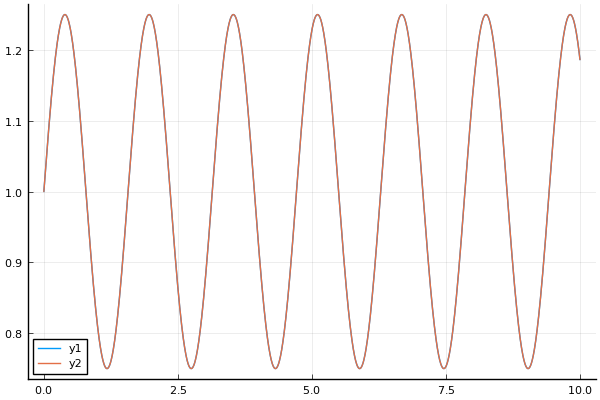

In [34]:
plot(T,uhist)
plot!(T,uex.(T))

### Advancing a combination of non-integrating factor systems

In [35]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

uex (generic function with 1 method)

In [36]:
ω₂ = 2
v₀ = 0.5
vex(t) = v₀ + sin(ω₂*t)/ω₂

vex (generic function with 1 method)

Note that r₁ receives the full tuple of states and returns a tuple

In [38]:
t = 0.0
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
ConstrainedSystems.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) =  ([cos(ω₁*t)], [cos(ω₂*t)])
solver = RK(u,Δt,ConstrainedSystems.r₁,rk=ConstrainedSystems.RK31)

Order-3 RK integator with
   State of type Tuple{Array{Float64,1},Array{Float64,1}}
   Time step size 0.005


In [39]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for ti in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = solver(t,u)
end

In [40]:
println("error for first element of tuple = ",norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",norm(u₂hist-vex.(T)))

error for first element of tuple = 0.0004948571451369004
error for second element of tuple = 0.00024362189412486005


### Advancing a combination of integrating factor systems

In [41]:
α₁ = 0.5
ω₁ = 4
u₀ = 1.0
uex(t) = u₀*exp(-α₁*t) + (α₁*(cos(ω₁*t)-exp(-α₁*t))+ω₁*sin(ω₁*t))/(α₁^2+ω₁^2)

uex (generic function with 1 method)

In [42]:
α₂ = 0.5
ω₂ = 2
v₀ = 0.5
vex(t) = v₀*exp(-α₂*t) + (α₂*(cos(ω₂*t)-exp(-α₂*t))+ω₂*sin(ω₂*t))/(α₂^2+ω₂^2)

vex (generic function with 1 method)

In [43]:
u = ([u₀],[v₀])

([1.0], [0.5])

In [44]:
plan1_intfact(t::Float64,u::Vector{Float64}) = exp(-α₁*t)
plan2_intfact(t::Float64,u::Vector{Float64}) = exp(-α₂*t)

plan2_intfact (generic function with 1 method)

In [46]:
t = 0.0
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
ConstrainedSystems.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) = ([cos(ω₁*t)], [cos(ω₂*t)])
solver = IFRK(u,Δt,(plan1_intfact,plan2_intfact),ConstrainedSystems.r₁,rk=ConstrainedSystems.RK31)

Order-3 IF-RK integator with
   State of type Tuple{Array{Float64,1},Array{Float64,1}}
   Time step size 0.005


In [48]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for ti in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = solver(t,u)
end

In [49]:
println("error for first element of tuple = ",norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",norm(u₂hist-vex.(T)))

error for first element of tuple = 0.0005014844446813186
error for second element of tuple = 0.00025562080196897416


### Advancing a combination of constrained integrating factor system and basic system


System 1

In [51]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [52]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ[1:n])
yb = 1.0 .+ R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f1 = ScalarData(X);

System 2

In [53]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

uex (generic function with 1 method)

Set up the state vector tuple and force tuple

In [54]:
u = (w,[u₀])
f = (f1,Vector{Float64}())
TU = typeof(u)
TF = typeof(f)

Tuple{ScalarData{128,Float64,Array{Float64,1}},Array{Float64,1}}

In [55]:
E = Regularize(X,dx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f1,w);

Set up the operators

In [56]:
ConstrainedSystems.r₁(u::TU,t::Float64) = (Nodes(Dual,w),[cos(ω₁*t)])
ConstrainedSystems.r₂(u::TU,t::Float64) = (ScalarData(ones(length(f1))),Vector{Float64}())
plans = (CartesianGrids.plan_intfact,(t,u) -> Matrix(1.0I,1,1))
plan_constraints(u::TU,t::Float64) = ((Hmat,f->zeros(Float64,1)),(Emat,u->Vector{Float64}()))

plan_constraints (generic function with 3 methods)

In [59]:
Δt = 0.01
solver = IFHERK(u,f,Δt,plans,plan_constraints,(ConstrainedSystems.r₁,ConstrainedSystems.r₂),rk=ConstrainedSystems.Euler,schursolver=Direct)

Order-1 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,129,129,Float64,Array{Float64,2}},Array{Float64,1}}
   Force of type Tuple{ScalarData{128,Float64,Array{Float64,1}},Array{Float64,1}}
   Time step size 0.01


In [60]:
solver(0.0,u)

(0.01, (Dual nodes in a (nx = 129, ny = 129) cell grid of type Float64 data
  Number of Dual nodes: (nx = 129, ny = 129), [1.01]), ([-340.2353879862708, -365.9353150487641, -348.1211528238947, -365.3756026257854, -342.44198023099443, -352.54876033651976, -356.08644372949374, -346.52023078204263, -350.6549393832741, -357.6318484955569  …  -338.50138372851586, -357.63184849555284, -350.654939383278, -346.5202307820465, -356.0864437294909, -352.5487603365193, -342.4419802309932, -365.37560262578756, -348.1211528238957, -365.9353150487625], Float64[]))

### Edge data

Here we will just test that we can advance edge-type data for the simplest possible system,

$\frac{\partial q}{\partial t} = 0$

In [61]:
nx = 10; ny = 10; q = Edges(Primal,(nx,ny));
q[20] = 5

5

The right-hand sides and operators here are all trivial

In [62]:
ConstrainedSystems.r₁(u::Edges,t::Float64) = zero(u)
ConstrainedSystems.r₂(u::Edges,t::Float64) = Vector{Float64}()  # no constraints, so constraints rhs is length 0
CartesianGrids.plan_intfact(t::Float64,u::Edges) = I
ConstrainedSystems.plan_constraints(u::Edges,t::Float64) = (f->zero(u),u->Vector{Float64}())

In [63]:
Δt = 0.01
f = Vector{Float64}()
u = deepcopy(q)
t = 0.0
solver = IFHERK(u,f,Δt,CartesianGrids.plan_intfact,ConstrainedSystems.plan_constraints,(ConstrainedSystems.r₁,ConstrainedSystems.r₂),rk=ConstrainedSystems.Euler,schursolver=Direct)

Order-1 IF-HERK integrator with
   State of type Edges{Primal,10,10,Float64,Array{Float64,1}}
   Force of type Array{Float64,1}
   Time step size 0.01


In [64]:
t,u,f = solver(t,u)

(0.01, Primal edges for a (nx = 10, ny = 10) cell grid of type Float64 data
  Internal u-faces: (nx = 10, ny = 9)
  Internal v-faces: (nx = 9, ny = 10), Float64[])

Check that the single non-trivial array element is still the same

In [65]:
u[20]

5.0